In [1]:
%load_ext autoreload
%autoreload 2

This notebook is a tentative overview of how we can use my custom library `neurgoo` to train ANNs.

Everything is written from scratch, directly utilizing `numpy`'s arrays and vectorizations.

`neurgoo`'s philosophy is to be as modular as possible, inspired from PyTorch's API design.

# Relevant Standard Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
from keras.datasets import mnist

2022-03-01 17:43:04.919335: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-01 17:43:04.919370: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
import tensorflow as tf

In [6]:
from pprint import pprint

# Data Preprocessing

In this section we:
- load MNIST data
- normalize pixels to [0, 1] (dividing pixel values by 255)
- do train/val/test splits.

## Train/Val/Test splits

Since we're using data from keras module, it only returns 

In [7]:
def load_data():
    """
        This loader function encapsulates preprocessing as well as data splits
    """
    (X_train, Y_train), (X_test, Y_test) = mnist.load_data()
    Y_train = tf.keras.utils.to_categorical(Y_train)
    Y_test = tf.keras.utils.to_categorical(Y_test)
    h, w = X_train[0].shape
    X_train = X_train.reshape((len(X_train), w*h))/255
    X_test = X_test.reshape((len(X_test), w*h))/255
    
    X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5)
    return (X_train, Y_train), (X_val, Y_val), (X_test, Y_test)

In [8]:
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = load_data()

In [9]:
X_train.shape, Y_train.shape

((60000, 784), (60000, 10))

In [10]:
X_val.shape, Y_val.shape

((5000, 784), (5000, 10))

In [11]:
X_test.shape, Y_test.shape

((5000, 784), (5000, 10))

# Custom Library implementation

Now, we're going to use my `neurgoo` library (see `neurgoo` packages).

There are mostly 5 components  that are needed for training:
- layers (either linear or activation)
- models (encapsulate N number of layers into a container)
- losses (compute loss and gradient to find final dJ/dW)
- optimizers (perform weight update operation)
- trainers (encapsulate all the training loop into one single coherent method)

> See the report for more details on the architecture and implementation

## Import all the necessary stuff

Note: Please `pip install requirements.txt` first.

`neurgoo` can also be installed locally as:
- `pip install -e .`
- or `python setup.py install`
- or simple copy-paste the package `neurgoo` anywhere to use it.

### Layers

In [12]:
from neurgoo.layers.linear import Linear
from neurgoo.layers.activations import(
    ReLU,
    Sigmoid,
    Softmax,
)

### Models

In [13]:
from neurgoo.models import DefaultNNModel

### Losses

In [14]:
from neurgoo.losses import (
    BinaryCrossEntropyLoss,
    CrossEntropyLossWithLogits,
    HingeLoss,
    MeanSquaredError,
)

### Optimizers

In [15]:
from neurgoo.optimizers import SGD

### Trainers

In [16]:
from neurgoo.trainers import DefaultModelTrainer

### Evaluators

In [17]:
from neurgoo.misc.eval import Evaluator

## Combine Components for training

Now we use available components to form one coherent trainer

### build model

We can add any number of layers. 

Each `Linear` layer can take `in_features` number of inputs and gives `num_neurons` number of output.

Linear layer also has different initialization methods which we can access right after building the layer object.
(This is like a builder design pattern):
- `initialize_random()` initializes weights randomly
- `initialize_gaussian(variance=...)` initializes weights from a gaussian distribution with **mu** centered at 0 and variance supplied

Each layer's forward pass is done through `feed_forward(...)` method.   
Each layer's backward pass is done through `backpropagate(...)` method.

### model 1

In [40]:
# a model with single hidden layer with 512 neurons
model = DefaultNNModel()
model.add_layer(
    Linear(num_neurons=512, in_features=X_train.shape[1])\
    .initialize_gaussian(variance=2/784)
)
model.add_layer(ReLU())
model.add_layer(Linear(num_neurons=10, in_features=512))

### model 2

In [41]:
# a model with single hidden layer with 128 neurons
model = DefaultNNModel()
model.add_layer(
    Linear(num_neurons=128, in_features=X_train.shape[1])\
    .initialize_gaussian(variance=2/784)
)
model.add_layer(ReLU())
model.add_layer(Linear(num_neurons=10, in_features=128))

### model 3

In [49]:
# a model with 2 hidden layers
model = DefaultNNModel()
model.add_layer(
    Linear(num_neurons=256, in_features=X_train.shape[1])\
    .initialize_gaussian(variance=2/784)
)
model.add_layer(ReLU())
model.add_layer(
    Linear(num_neurons=128, in_features=256)\
    .initialize_gaussian(variance=2/256)
)
model.add_layer(ReLU())
model.add_layer(Linear(num_neurons=10, in_features=128))

#### model 4

In [22]:
# a model with 2 hidden layers
model = DefaultNNModel()
model.add_layer(
    Linear(num_neurons=512, in_features=X_train.shape[1]).initialize_gaussian()
)
model.add_layer(ReLU())
model.add_layer(
    Linear(num_neurons=256, in_features=512).initialize_gaussian()
)
model.add_layer(ReLU())
model.add_layer(Linear(num_neurons=10, in_features=256))

In [50]:
print(model)

[Model=(DefaultNNModel, DefaultNNModel)]
num_layers=5
Layers=[
Linear || Shape: ((None, 784), (None, 256)) || trainable: True
ReLU || Attrs => {'_input_cache': array(0), 'mode': 'train'}
Linear || Shape: ((None, 256), (None, 128)) || trainable: True
ReLU || Attrs => {'_input_cache': array(0), 'mode': 'train'}
Linear || Shape: ((None, 128), (None, 10)) || trainable: True
]


### build optimizer

In [51]:
params = model.params()
print(params)

(OptimParam || requires_grad=True || val_shape = (784, 256) || grad_shape = (), OptimParam || requires_grad=True || val_shape = (1, 256) || grad_shape = (), OptimParam || requires_grad=True || val_shape = (256, 128) || grad_shape = (), OptimParam || requires_grad=True || val_shape = (1, 128) || grad_shape = (), OptimParam || requires_grad=True || val_shape = (128, 10) || grad_shape = (), OptimParam || requires_grad=True || val_shape = (1, 10) || grad_shape = ())


In [54]:
optimizer = SGD(params=params, lr=0.001)

### build loss

In [55]:
# loss = CrossEntropyLossWithLogits()
loss = HingeLoss()

### build trainer

In [56]:
# helper component for evaluating the model
evaluator = Evaluator(num_classes=10)

In [57]:
trainer = DefaultModelTrainer(
    model=model,
    optimizer=optimizer,
    evaluator=evaluator,
    loss=loss,
    debug=False,
)

## Start Training

We call `fit(...)` method of the trainer.The trainer takes in splitted data, number of epochs and batch_size.

Once the training is done, we get a ``dict`` that represents history of train/val/test for each epoch.
> Note: test is evaluated only when the whole training is complete,  after the end of last epoch.

During training, several debug logs are also printed like:
- Information about number of epochs passed
- Train accuracy/loss
- Validation accuracy/loss

In [58]:
print(model[-1], loss)

Linear || Shape: ((None, 128), (None, 10)) || trainable: True <neurgoo.losses.HingeLoss object at 0x7ff8f1b60c70>


In [59]:
history = trainer.fit(
    X_train=X_train,
    Y_train=Y_train,
    X_val=X_val,
    Y_val=Y_val,
    X_test=X_test,
    Y_test=Y_test,
    nepochs=75,
    batch_size=64,
)

2022-03-01 17:54:27.688 | INFO     | neurgoo.trainers:fit:83 - Training | nepochs=75 | batch_size=64
938it [00:06, 137.03it/s]
2022-03-01 17:54:35.799 | DEBUG    | neurgoo.trainers:fit:142 - Epoch=1/75 | Epoch Train Cost=2.388252621715065 | | Epoch Val Cost=0.8745363463226647 | Train Acc=0.8517833333333333 | Val Acc=0.8674 | Delta time=7.956098318099976
938it [00:06, 150.80it/s]
2022-03-01 17:54:43.204 | DEBUG    | neurgoo.trainers:fit:142 - Epoch=2/75 | Epoch Train Cost=0.784920109563179 | | Epoch Val Cost=0.6211433984710664 | Train Acc=0.8816333333333334 | Val Acc=0.8902 | Delta time=7.179432153701782
938it [00:07, 126.58it/s]
2022-03-01 17:54:51.809 | DEBUG    | neurgoo.trainers:fit:142 - Epoch=3/75 | Epoch Train Cost=0.6160126179947839 | | Epoch Val Cost=0.5284961513639943 | Train Acc=0.8943 | Val Acc=0.9026 | Delta time=8.382171154022217
938it [00:07, 122.00it/s]
2022-03-01 17:55:00.708 | DEBUG    | neurgoo.trainers:fit:142 - Epoch=4/75 | Epoch Train Cost=0.5357843644835831 | | Ep

938it [00:07, 122.80it/s]
2022-03-01 18:04:36.558 | DEBUG    | neurgoo.trainers:fit:142 - Epoch=66/75 | Epoch Train Cost=0.11823044710031341 | | Epoch Val Cost=0.14109951719706437 | Train Acc=0.971 | Val Acc=0.9688 | Delta time=8.750400066375732
938it [00:07, 124.55it/s]
2022-03-01 18:04:45.430 | DEBUG    | neurgoo.trainers:fit:142 - Epoch=67/75 | Epoch Train Cost=0.11669293694670949 | | Epoch Val Cost=0.14005406445236837 | Train Acc=0.9709 | Val Acc=0.9682 | Delta time=8.632511854171753
938it [00:07, 130.87it/s]
2022-03-01 18:04:53.945 | DEBUG    | neurgoo.trainers:fit:142 - Epoch=68/75 | Epoch Train Cost=0.11529454203564653 | | Epoch Val Cost=0.13826342622682297 | Train Acc=0.9713333333333334 | Val Acc=0.9696 | Delta time=8.27390456199646
938it [00:07, 121.27it/s]
2022-03-01 18:05:02.977 | DEBUG    | neurgoo.trainers:fit:142 - Epoch=69/75 | Epoch Train Cost=0.11389750633339624 | | Epoch Val Cost=0.13725092729057983 | Train Acc=0.9716166666666667 | Val Acc=0.9692 | Delta time=8.786540

### Understanding history

The history `dict` returned by the trainer consits of training history for train/val/test.

The `train` and `val`  consists of list of `neurgoo.misc.eval.EvalData` objects. Each `EvalData` object can store:
- epoch
- loss
- accuracy
- precision (to be implemented)
- recall (to be implemented)

Unlike `train` and `val`, the `test` history is a single `EvalData` object, not a list which stores final evaluation data after the end of the training.

In [60]:
history["train"][:10]

[EvalData(epoch=1, accuracy=0.8517833333333333, precision=-1, recall=-1, loss=2.388252621715065),
 EvalData(epoch=2, accuracy=0.8816333333333334, precision=-1, recall=-1, loss=0.784920109563179),
 EvalData(epoch=3, accuracy=0.8943, precision=-1, recall=-1, loss=0.6160126179947839),
 EvalData(epoch=4, accuracy=0.9013333333333333, precision=-1, recall=-1, loss=0.5357843644835831),
 EvalData(epoch=5, accuracy=0.9068333333333334, precision=-1, recall=-1, loss=0.4867780047229557),
 EvalData(epoch=6, accuracy=0.9114833333333333, precision=-1, recall=-1, loss=0.45185245088564),
 EvalData(epoch=7, accuracy=0.91515, precision=-1, recall=-1, loss=0.4246390236342028),
 EvalData(epoch=8, accuracy=0.9190666666666667, precision=-1, recall=-1, loss=0.40305102702706097),
 EvalData(epoch=9, accuracy=0.92195, precision=-1, recall=-1, loss=0.3844931098643734),
 EvalData(epoch=10, accuracy=0.92485, precision=-1, recall=-1, loss=0.36868778362916954)]

In [61]:
history["val"][:10]

[EvalData(epoch=1, accuracy=0.8674, precision=-1, recall=-1, loss=0.8745363463226647),
 EvalData(epoch=2, accuracy=0.8902, precision=-1, recall=-1, loss=0.6211433984710664),
 EvalData(epoch=3, accuracy=0.9026, precision=-1, recall=-1, loss=0.5284961513639943),
 EvalData(epoch=4, accuracy=0.909, precision=-1, recall=-1, loss=0.47725617069814097),
 EvalData(epoch=5, accuracy=0.9146, precision=-1, recall=-1, loss=0.44310650297232507),
 EvalData(epoch=6, accuracy=0.9164, precision=-1, recall=-1, loss=0.41631436221160495),
 EvalData(epoch=7, accuracy=0.924, precision=-1, recall=-1, loss=0.3946568080575891),
 EvalData(epoch=8, accuracy=0.924, precision=-1, recall=-1, loss=0.37940973762074826),
 EvalData(epoch=9, accuracy=0.929, precision=-1, recall=-1, loss=0.3635861857418352),
 EvalData(epoch=10, accuracy=0.9294, precision=-1, recall=-1, loss=0.3514930871018958)]

In [62]:
history["test"]

EvalData(epoch=75, accuracy=0.968, precision=-1, recall=-1, loss=0.14396271524315854)

### Plot history

We use the plotting tools from neurgoo.

The `plot_history` is convenient helper that takes in the history dict and plots the metrics.
Since, we can plot train-vs-val losses and accuracies, the parameter `plot_type` controls what type of plot we want.
- `plot_type="loss"` for plotting losses
- `plot_type="accuracy"` for plotting accuracies

In [63]:
from neurgoo.misc.plot_utils import plot_history

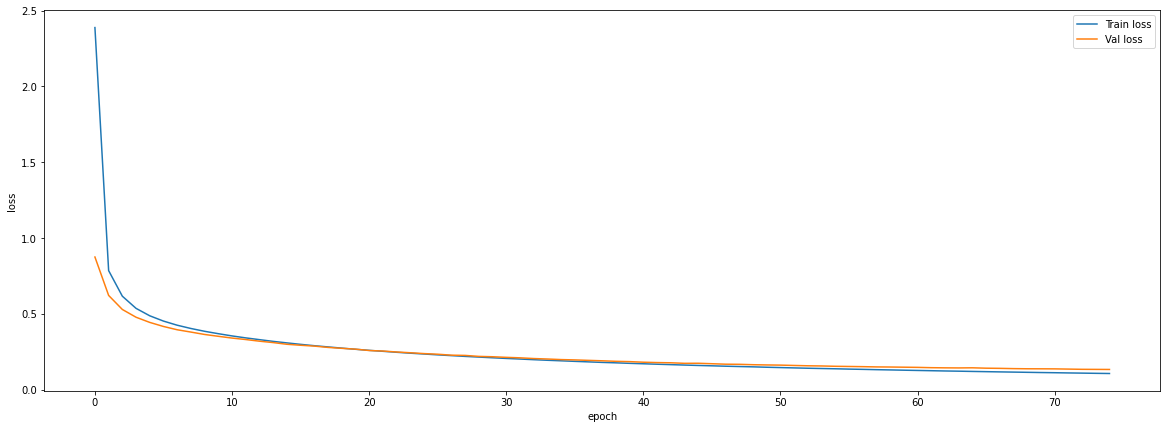

In [64]:
plot_history(history, plot_type="loss")

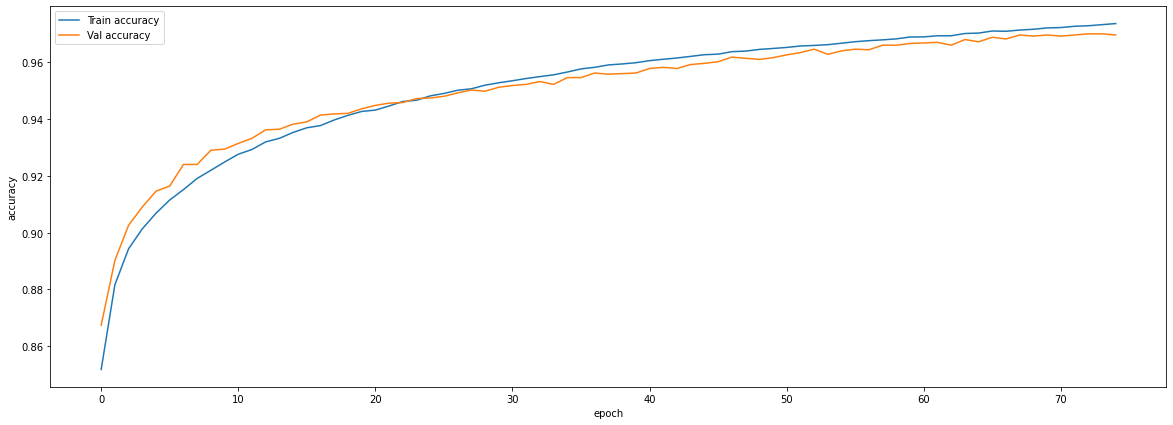

In [65]:
plot_history(history, plot_type="accuracy")

# Inference Debug

Now that we have trained our model, we can do inference directly through its `predict(...)` method
which takes in X values and gives final output.

In this section we will do infernece on a random test data point.

The `plot_images` will plot image as well as the label assigned from target or got from predictions (np.argmax).
For the predicted Y values, we also add a probability text beside the label to debug the probabilities.


## Note

If we have the final layer as `neurgoo.layers.activations.Softmax`, we can get normalized probabilities directly from the prediction.

If we have usual `Linear` layer in the last, we won't have normalized probabilitites. So, we need to pass the prediction to a Softmax and then get the probabilities.

In [66]:
import random

In [67]:
def plot_images(X, Y, cols=5, title=""):
    print(f"X.shape: {X.shape} | Y.shape: {Y.shape}")
    _, axes = plt.subplots(nrows=1, ncols=cols, figsize=(10, 3))
    n = int(X.shape[1]**0.5)
    probs = Softmax()(Y)
    for ax, img, t, p in zip(axes, X, Y, probs):
        label = np.argmax(t)
        prob = round(np.max(p), 3)
        img = img.reshape((n, n))
        ax.set_axis_off()
        ax.imshow(img, cmap=plt.cm.gray_r, interpolation="nearest")
        txt = f"{title}: {label}"
        txt = f"{txt}({prob})" if "inf" in title.lower() else txt
        ax.set_title(txt)

In [68]:
X_test.shape, Y_test.shape

((5000, 784), (5000, 10))

X.shape: (7, 784) | Y.shape: (7, 10)
X.shape: (7, 784) | Y.shape: (7, 10)
X.shape: (7, 784) | Y.shape: (7, 10)
X.shape: (7, 784) | Y.shape: (7, 10)


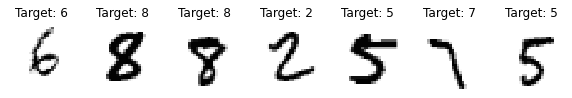

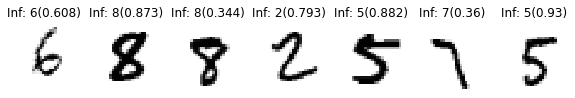

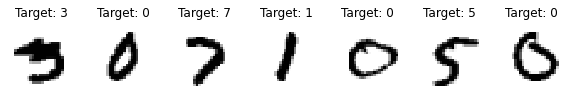

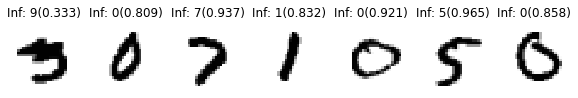

In [71]:
model.eval_mode()
k = 7
for i in range(2):
    indices_infer = random.choices(range(len(X_test)), k=k)
    X_infer, Y_infer_target = X_test[indices_infer], Y_test[indices_infer]
    
    # forward pass
    predictions = model.predict(X_infer)
    
    plot_images(X_infer, Y_infer_target, cols=k, title="Target")
    plot_images(X_infer, predictions, cols=k, title="Inf")

# Observations

1) For visually similar numbers like 7 and 1, sometimes the model is less confidence while trying to predict for the number **7**. In such cases, we have relatively lower probabilities like `0.8`, `0.9`, etc. This can be mitigated if we "properly" trained the model with:
    - better architecture
    - more training time
    - adding regularizations and dropout tricks
    
2) For unique images like `0, 5, 6`, we see high probilities as the model doesn't get "confused" much.

# Further Improvements to neurgoo

There's definitely more rooms for improvement in `neurgoo`. We could:
- implement `Dropout` and `BatchNorm` layers at `neurgoo.layers` using the base class `neurgoo._base.AbstractLayer`
- add regularization techniques
- implement better optimizers such as addition of Nesterov momentum, Adam optimizers, etc. This could be done by adding new optimizer components at `neurgoo.optimizers`, directly derived from `neurgoo._base.AbstractOptimizer`
- use automatic differentiation techniques [0] for computing accurate gradients.

# References and footnotes

- [0] - https://en.wikipedia.org/wiki/Automatic_differentiation
- [PyTorch Internals](http://blog.ezyang.com/2019/05/pytorch-internals/)
- [How Computational Graphs are Constructed in PyTorch](https://pytorch.org/blog/computational-graphs-constructed-in-pytorch/)
- [Why is the ReLU function not differentiable at x=0?](https://sebastianraschka.com/faq/docs/relu-derivative.html)